In [ ]:
! pip install pillow boto3 pillow -q 

In [2]:
import boto3
import glob
from PIL import Image   
import re
import pandas as pd
from dotenv import load_dotenv
from IPython.display import display
import os
load_dotenv()

True

## Part 1: Upload Raw Images to S3

In [29]:
import os

folder_path = 'Images'
jpg_files = []
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.lower().endswith('.jpg'):
            jpg_files.append(os.path.join(root, file))
# Images/*.jpg Format

s3_client = boto3.client('s3')
bucket = "techcatalyst-raw"
prefix = "BLAKE/AI/IMAGES_RAW/"
for jpg in jpg_files:
    filename = os.path.basename(jpg)
    s3_loc = f"{prefix}{filename}"
    s3_client.upload_file(jpg, bucket, s3_loc)




## Part 2: Analyze Images with Rekognition

In [41]:
rekognition_client = boto3.client('rekognition')

In [45]:
bucket_name = "techcatalyst-raw"
rekognition_output = []


objects_list = s3_client.list_objects_v2(Bucket=bucket_name, Prefix="BLAKE/AI/IMAGES_RAW").get("Contents")
for obj in objects_list:
    obj_name = obj["Key"]
    response = rekognition_client.detect_text(
        Image={'S3Object': {'Bucket': bucket_name, 'Name': obj_name}}
    )
    detected_text = [item['DetectedText'] for item in response['TextDetections'] if item['Type'] == 'WORD']
    rekognition_output.append({
        'image_name': obj_name.split('/')[-1], # Get just the filename
        'labels': detected_text
    })




In [46]:
rekognition_output

[{'image_name': '19306e847f2dbe79.jpg',
  'labels': ['VA',
   '4164979',
   'NOV',
   'VIRGINIA',
   'VA',
   '6175063',
   '15',
   'JEUN',
   'INEE',
   'PARK',
   'JAMES',
   'RIVER',
   'SYSTEM']},
 {'image_name': '1ac5b485b95c9f00.jpg',
  'labels': ['MO', 'California', 'YA', 'LAFIAT']},
 {'image_name': '1c00790f8e592ab2.jpg',
  'labels': ['VA',
   '4713476',
   'VA',
   '5278850',
   'VIRGINIA',
   '16',
   'AUG',
   'OPA',
   'OPA',
   'VIRGINIA',
   'IS',
   'FOR',
   'LOVERS',
   'Virginia.org']},
 {'image_name': '1c62dcbf9a6c22c7.jpg',
  'labels': ['STANFORD',
   'UNIVERSITY',
   'APR',
   '2013',
   'California',
   'GOGLGRL',
   'STANPORD',
   'MESCUR',
   'MOUNTAINESS']},
 {'image_name': '1d5b964bef140076.jpg',
  'labels': ['VA',
   '4304826',
   'JUN',
   'VIRGINIA',
   'VA',
   '3760058',
   '10',
   'HIZK',
   'ILL']},
 {'image_name': '27801b00dbefaa6d.jpg',
  'labels': ['TOYOTA',
   'GT-S',
   '8 16',
   'PENNSYLVANIA',
   'JXS.5990',
   'visitPA.com']},
 {'image_name':

In [44]:
car_makes = [
    'TOYOTA', 'HONDA', 'FORD', 'CHEVROLET', 'NISSAN', 'JEEP', 'HYUNDAI', 'KIA',
    'SUBARU', 'RAM', 'GMC', 'BMW', 'MERCEDES-BENZ', 'LEXUS', 'AUDI', 'VOLKSWAGEN',
    'TESLA', 'ACURA', 'CADILLAC', 'CHRYSLER', 'DODGE', 'INFINITI', 'LINCOLN', 'MAZDA'
]

# List of full US state names for searching
us_state_names = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa',
    'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
    'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
    'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island',
    'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
    'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia'
]

In [47]:
processed_data = []

# Loop through the raw data we collected from Rekognition
for item in rekognition_output:
    image_name = item['image_name']
    
    # Use the correct key 'labels' to access the list of words.
    full_text = " ".join(item['labels']).upper()
    
    found_make = None
    found_state = None
    
    # --- Find Car Make ---
    for make in car_makes:
        if make in full_text:
            found_make = make.title()
            break 
            
    # --- Find State Name ---
    for state_name in us_state_names:
        if state_name.upper() in full_text:
            found_state = state_name
            break

    # Add the extracted info to our list
    processed_data.append({
        'image_name': image_name,
        'make': found_make,
        'state': found_state
    })

print("Data processing complete.")

Data processing complete.


In [48]:
df = pd.DataFrame(processed_data)

# For better presentation, replace Python's 'None' with a 'Not Found' string
df.fillna('Not Found', inplace=True)

print("Final DataFrame:")
display(df)

Final DataFrame:


,image_name,make,state
0,19306e847f2dbe79.jpg,Not Found,Virginia
1,1ac5b485b95c9f00.jpg,Not Found,California
2,1c00790f8e592ab2.jpg,Not Found,Virginia
3,1c62dcbf9a6c22c7.jpg,Ford,California
4,1d5b964bef140076.jpg,Not Found,Virginia
5,27801b00dbefaa6d.jpg,Toyota,Pennsylvania
6,29ab3cf353e1f894.jpg,Honda,Texas
7,2c57bd6d734b6ff3.jpg,Not Found,California
8,2c75228218b9f9c5.jpg,Not Found,California
9,2f6fbf1e163dd7ed.jpg,Not Found,Virginia


## Part 3: Store results as a parquet file

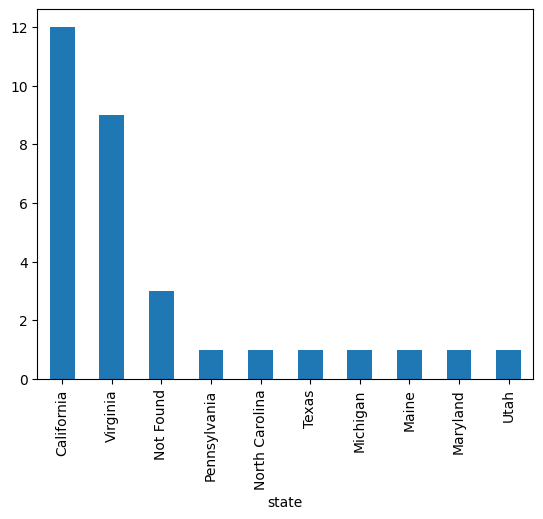

In [ ]:

import matplotlib.pyplot as plt

state_counts = df['state'].value_counts()
state_counts.plot(kind="bar")

plt.savefig('state_counts.jpg')



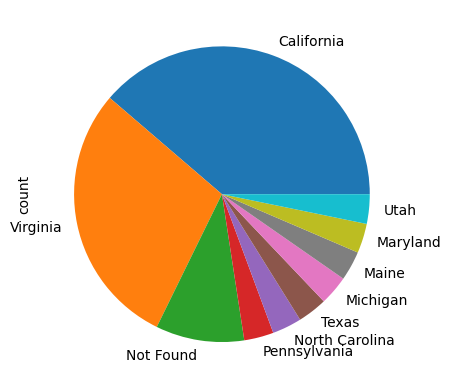

In [70]:
state_counts.plot(kind="pie")
plt.savefig('State Distribution of Detected License Plates.jpg')

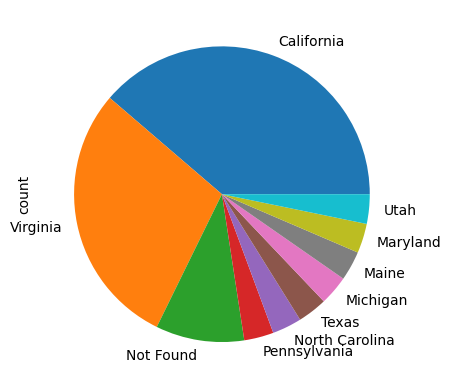

In [72]:
make_counts = df['make'].value_counts()
state_counts.plot(kind="pie")

plt.savefig('make_counts.jpg')


In [53]:
import awswrangler as wr
wr.s3.to_parquet(
    df=df,
    path="s3://techcatalyst-raw/BLAKE/AI/IMAGES_PROCESSED/processed_car_data.parquet"
)

{'paths': ['s3://techcatalyst-raw/BLAKE/AI/IMAGES_PROCESSED/processed_car_data.parquet'],
 'partitions_values': {}}

In [ ]:
wr.s3.upload(
    local_file="state_counts.jpg",
    path="s3://techcatalyst-raw/BLAKE/AI/IMAGES_PROCESSED/state_counts.jpg"
)

wr.s3.upload(
    local_file="State Distribution of Detected License Plates.jpg",
    path="s3://techcatalyst-raw/BLAKE/AI/IMAGES_PROCESSED/State Distribution of Detected License Plates.jpg"
)

wr.s3.upload(
    local_file="make_counts.jpg",
    path="s3://techcatalyst-raw/BLAKE/AI/IMAGES_PROCESSED/make_counts.jpg"
)